In [1]:
import math
import pynq
from pynq import Overlay
from pynq import Xlnk
xlnk = Xlnk()
xlnk.xlnk_reset()

import numpy as np

import cv2


In [2]:
overlay = Overlay('./files/lk.bit')
#overlay?

In [3]:
lk = overlay.hls_LK_0
dma0 = overlay.axi_dma_0 # inp1_img, vx_img
dma1 = overlay.axi_dma_1 # inp2_img, vy_img

In [4]:
def dma_reset():
    dma0.sendchannel.stop() # inp1_img
    dma0.sendchannel.start() 
    dma1.sendchannel.stop() # inp2_img
    dma1.sendchannel.start()
    dma0.recvchannel.stop() # vx_img
    dma0.recvchannel.start()
    dma1.recvchannel.stop() # vy_img
    dma1.recvchannel.start()
    
dma_reset()

In [5]:
(row,col,ch) = (256,256,1)

## read images
img1 = cv2.imread("files/img_00000.jpg")
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img1 = cv2.resize(img1,(col,row))

img2 = cv2.imread("files/img_00001.jpg")
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img2 = cv2.resize(img2,(col,row))

## share memory
inp1_img = xlnk.cma_array(shape=(row,col,ch), dtype=np.uint8)
inp2_img = xlnk.cma_array(shape=(row,col,ch), dtype=np.uint8)
vx_img = xlnk.cma_array(shape=(row,col), dtype=np.int8)
vy_img = xlnk.cma_array(shape=(row,col), dtype=np.int8)

inp1_img[:row,:col,0] = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
inp2_img[:row,:col,0] = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)


In [6]:

def lk_optical_flow():
    dma_reset()
    dma0.sendchannel.transfer(inp1_img)
    dma1.sendchannel.transfer(inp2_img)
    dma0.recvchannel.transfer(vx_img)
    dma1.recvchannel.transfer(vy_img)
    lk.write(0x20, col) #width
    lk.write(0x18, row) #height
    lk.write(0x00, 0x81)
    dma0.recvchannel.wait()
    dma1.recvchannel.wait()
    
lk_optical_flow()


In [7]:
%timeit lk_optical_flow()

1.15 ms ± 677 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


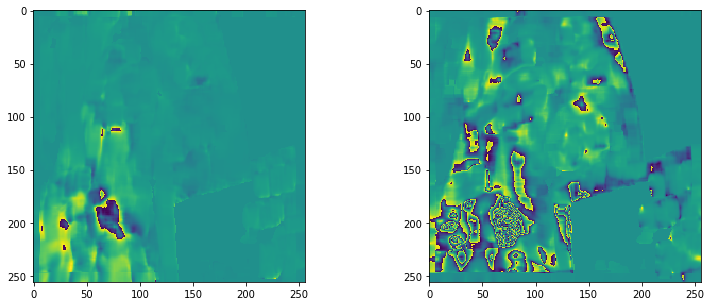

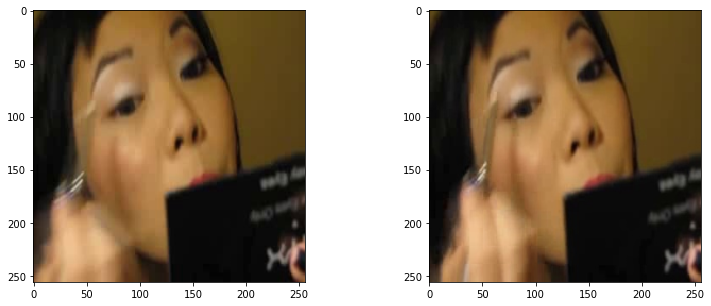

In [8]:

import matplotlib.pyplot as plt
%matplotlib inline

fig=plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.imshow(vx_img)
plt.subplot(1,2,2)
plt.imshow(vy_img)
plt.show()

fig=plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.imshow(img1)
plt.subplot(1,2,2)
plt.imshow(img2)
plt.show()
